# Artificial neural network for Water Distribution Systems Metamodelling - Machine learning project (1/2)

### ☑ <font color='#0096FF'>Blue-tape list<font><a class='anchor' id='top'></a>

 <font color='#0096FF'>
<!-- <div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;"> -->

- Define more specific objectives
- Explain what is a metamodel 
- Check dependencies
- Renormalize without considering the reservoirs
- Add the ML Development cycle image

**Objectives:**
- Implement an artificial neural network (ANN) to metamodel a water distribution system.

**Completition requirements:**

By the end of this notebook, you should have:
- Implemented all the code cells for:
  - Loading the dataset of simulations
  - Defining an ANN
  - Training the ANN
  - Testing the performance of the ANN
  - Saving the metamodel for later use
- Answered all the questions

## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:
- Pandas
- Numpy
- Matplotlib
- Pickle
- Scikit-learn

In [2]:
import time
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## 🔙 Background

### 💧 Water distribution systems

Water utilities rely on hydrodynamic models to properly design and control water distribution systems (WDSs). These physically-based models, such as [EPANET](https://www.epa.gov/water-research/epanet), compute the state of the system, i.e., the flow rates and pressures at all the pipes and junctions, as illustrated in Figure 1. 

Hydrodynamic models provide valuable insight into the functioning of the system. However, the computational speed of these models is often insufficient for some applications in civil engineering such as optimisation of design or criticality assessment, especially in large search space problems. 

One alternative to address this issue is developing data-driven models. These models are trained using results calculated using the original model (EPANET, in this case) in multiple scenarios. The objective of the data-driven models is to estimate the output of the original model but in a shorter time.

### 🖥Numerical model

Metamodels

### 🤖Artificial Neural Network (ANN)

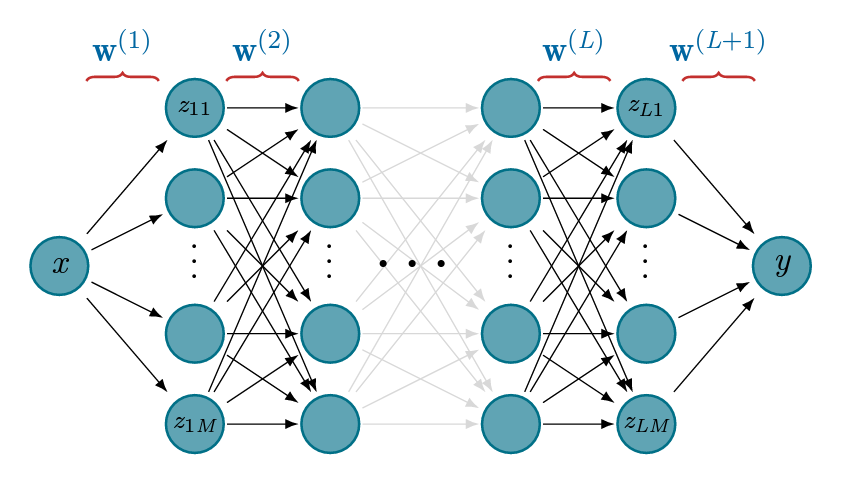

## ⛔ Problem definition 

The problem is to create an alternative model of WNTR using an ANN. The metamodel should give approximate solution while being faster to run. 


ML development cycle

## 🏋🏽‍♀️ Exercise: Metamodel

### Load the database of examples

Training

In [3]:
file_path = r"./Datasets/Modena/features_Modena_training.p"
with open(file_path, 'rb') as handle:
    training_features = pickle.load(handle)

file_path = r"./Datasets/Modena/targets_Modena_training.p"
with open(file_path, 'rb') as handle:
    training_targets = pickle.load(handle)

Validation

In [4]:
file_path = r"./Datasets/Modena/features_Modena_validation.p"
with open(file_path, 'rb') as handle:
    validation_features = pickle.load(handle)

file_path = r"./Datasets/Modena/targets_Modena_validation.p"
with open(file_path, 'rb') as handle:
    validation_targets = pickle.load(handle)

### Data pre-processing

In [5]:
# set up scalers and scale data
# xscaler, yscaler = MinMaxScaler(), MinMaxScaler()
# xit = xscaler.inverse_transform
# yit = yscaler.inverse_transform


# xscaler.fit_transform(training_features.reshape(-1, 1))
# yscaler.fit_transform(training_targets.reshape(-1, 1))

critical_node_ID = 193

slice_critical_node = training_targets[:, critical_node_ID]
slice_critical_node_val = validation_targets[:, critical_node_ID]

training_targets= slice_critical_node#.reshape(-1,1)
validation_targets= slice_critical_node_val#.reshape(-1,1)

max_feature = training_features.max()
max_target = training_targets.max()
min_feature = training_features.min()
min_target = training_targets.min()
# max_feature = training_features.max()
# max_feature = training_features.max()

# print(max_feature)
# print(max_target)
# print(min_feature)
# print(min_target)

def min_max_normalize(data, min, max):
    return (data-min)/(max-min)

def inverse_min_max_normalize(data, min, max):
    return (data)*(max-min)+min


X_train = min_max_normalize(training_features, min_feature, max_feature)
y_train = min_max_normalize(training_targets, min_target, max_target)

X_val = min_max_normalize(validation_features, min_feature, max_feature)
y_val = min_max_normalize(validation_targets, min_target, max_target)




### Define the metamodel

#### Linear Model

First, let's try a linear model with linear features. We use the `MLPRegressor` to stay consistent with the workflow for the rest of the notebook. A linear model with linear features can be obtained by setting the activation function to be the identity. The inputs are multiplied with the weights twice &mdash; once before and once after the hidden layer. However, the linear combination of linear models will still result in a linear model, which makes this little trick work. The training is trivial, and we therefore employ the built-in `MLPRegressor.fit()` function to this end.

In [16]:
y_train.shape

(8000,)

In [17]:
# Set up linear regression model
linear_model = MLPRegressor(solver='sgd', 
                            hidden_layer_sizes=(10), 
                            activation='identity', 
                            learning_rate='constant',
                            # verbose = True
                            )

# train NN
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_val)

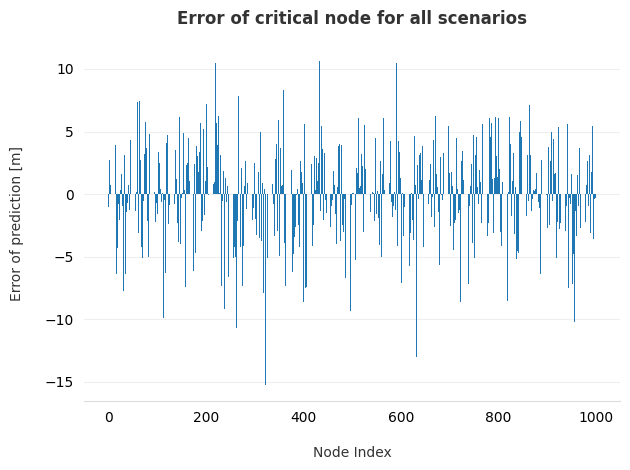

In [28]:
error = inverse_min_max_normalize(y_val, min_target, max_target) - inverse_min_max_normalize(y_pred, min_target, max_target)

fig, ax = plt.subplots()

bars = ax.bar(
    x=np.arange(error.size),
    height=error,
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Node Index', labelpad=15, color='#333333')
ax.set_ylabel('Error of prediction [m]', labelpad=15, color='#333333')
ax.set_title(f'Error of critical node for all scenarios', pad=15, color='#333333', weight='bold')

fig.tight_layout()

This is not awful, but we can do better then that. Now, let's try a nonlinear model. As you might already have guessed from the implementation of the linear model, we propose a neural network. We also discard the `MPLRegressor.fit()` function and implement the training loop our selves, to be able to take a look under the hood.

#### Artificial Neural Network

With our dataset ready, we can create a function to train a neural network (NN). There are many choices to be made when creating such a function, most are related to the bias - variance tradeoff discussed in the lectures. The outline of the function we want to create is as follows:

`def NN_train()`:<br>
&emsp;&emsp; For a maximum number of epochs:<br>
&emsp;&emsp;&emsp;&emsp; Permutate the data<br> 
&emsp;&emsp;&emsp;&emsp; For every minibatch:<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Collect the X & y training data<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Take a NN step (partial fit)<br> 
&emsp;&emsp;&emsp;&emsp; Compute the root mean squared error (RMSE) on the validation set<br> 
&emsp;&emsp;&emsp;&emsp; If the RMSE is the lowest:<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Save the RMSE & NN model<br> 
&emsp;&emsp;&emsp;&emsp; If RMSE has not decreased in the last X epochs<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Stop the training loop<br> 
&emsp;&emsp;&emsp;&emsp; Adapt the learning rate if necessary<br> 
&emsp;&emsp; Return NN, rmse_min & full_rmse_array<br>

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task:</b>
    Go through the training loop algorithm and compare with the code. The code is **not** complete. Identify what bits are missing and implement them.
</p>
</div>

In [7]:
# function to train the NN
def NN_train(NN, X_train, y_train, X_val, y_val, 
             max_epoch=100000, 
             tol=1e-6, 
             verbose=False, 
             lr_init=1e-2, 
             lr_pow=0.9, 
             lr_step=500, 
             seed=0, 
             batchsize=50):
    
    # set seed 
    np.random.seed(seed)
    
    # set up array for mse and improvement count for early stopping
    rmse = [] 
    rmse_min = 1e10
    no_improvement_count = 0
    
    # init learning rate
    lr = lr_init
    NN.learning_rate_init = lr
    
    NN_best = NN
    
    # loop over iterations
    for epoch in range(max_epoch):
            
        # set up permutation of the data
        n = X_train.shape[0]
        perm = np.random.permutation(n)
        batches_per_epoch = int(np.floor(n/batchsize))
        
        # loop over batches
        for it in range(batches_per_epoch):
            
            # collect current batch
            X_batch = X_train[perm[it*batchsize:(it+1)*batchsize]]
            y_batch = y_train[perm[it*batchsize:(it+1)*batchsize]]
                
            # take step
            NN.partial_fit(X_batch, y_batch)
            
        # compute rmse on validation set after each epoch
        y_val_hat = NN.predict(X_val)
        rmse.append(np.sqrt(np.sum((y_val - y_val_hat)**2)/len(y_val)))
        
        # adapt learning rate
        if (epoch > 0) and (epoch%lr_step==0):
            lr *= lr_pow
            NN.learning_rate_init = lr
            if verbose:
                print("Reduced learning rate to {:.4e}".format(lr))
        
        # check if no improvement occured in last iters
        if rmse[-1] - rmse_min > tol:
            no_improvement_count += 1
        elif rmse[-1] < rmse_min:
            rmse_min = rmse[-1]
            no_improvement_count = 0
            NN_best = NN
        
        # exit loop when no improvement was registered during past twenty iters
        if no_improvement_count == 20:
            print("Training stopped after {} epochs".format(epoch))
            break
        
        # print loss (optional)
        if verbose and epoch%2==0:
            print("\nIteration {}".format(epoch))
            print("   rmse {:.4e}\n".format(rmse[epoch]))
    
    if (epoch==max_epoch-1): print("Reached max_epochs ( {} )".format(max_epoch))
    
    # return trained network and last rmse
    return NN_best, rmse_min, rmse

In [46]:
# Set up NN
NN = MLPRegressor(solver='adam', 
                  hidden_layer_sizes=(128, 128, 128, 128), 
                  activation='relu',
                  batch_size = 32,
                  learning_rate='constant',
                  )

# train NN
NN, _, rmse = NN_train(NN, X_train, y_train, X_val, y_val, max_epoch=100, verbose=True, lr_init=1e-1, lr_step=50)


Iteration 0
   rmse 9.6071e-01


Iteration 2
   rmse 8.0074e-01


Iteration 4
   rmse 5.8639e-01


Iteration 6
   rmse 3.6825e-01


Iteration 8
   rmse 1.9117e-01


Iteration 10
   rmse 8.3828e-02


Iteration 12
   rmse 4.6340e-02


Iteration 14
   rmse 4.2163e-02


Iteration 16
   rmse 4.2019e-02


Iteration 18
   rmse 4.2016e-02


Iteration 20
   rmse 4.2012e-02


Iteration 22
   rmse 4.2005e-02


Iteration 24
   rmse 4.2005e-02


Iteration 26
   rmse 4.2005e-02


Iteration 28
   rmse 4.2039e-02


Iteration 30
   rmse 4.2014e-02


Iteration 32
   rmse 4.2009e-02


Iteration 34
   rmse 4.2021e-02


Iteration 36
   rmse 4.2112e-02


Iteration 38
   rmse 4.2005e-02


Iteration 40
   rmse 4.2007e-02


Iteration 42
   rmse 4.2177e-02


Iteration 44
   rmse 4.2866e-02


Iteration 46
   rmse 4.2099e-02


Iteration 48
   rmse 4.2222e-02

Reduced learning rate to 9.0000e-02

Iteration 50
   rmse 4.2265e-02


Iteration 52
   rmse 4.2241e-02


Iteration 54
   rmse 4.2463e-02


Iteration 56
   

You can use the following plotting routines to visualize your predictions. Keep in mind that all of the following graphs are based on projections of the input data on 1D or 2D subspaces that suppress at least part of the information contained in the dataset. Those projections, however, are necessary to enable visualizations of the predictions.

<Axes: >

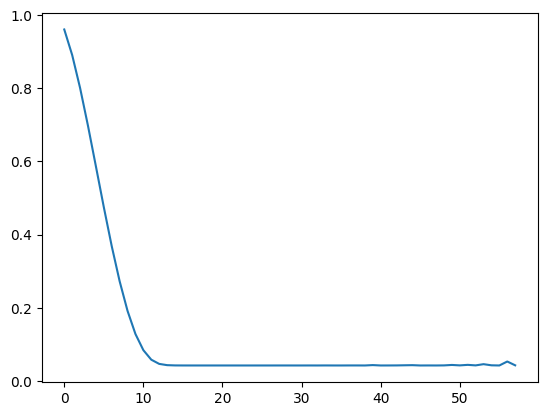

In [47]:
import pandas as pd
pd.Series(rmse).plot()

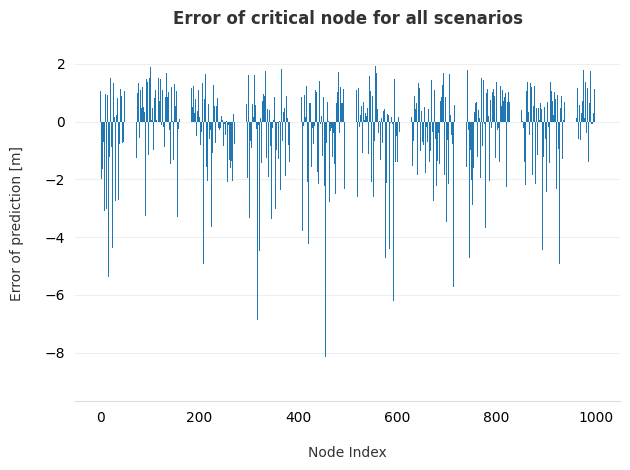

In [48]:
y_pred = NN.predict(X_val)

error = inverse_min_max_normalize(y_val, min_target, max_target) - inverse_min_max_normalize(y_pred, min_target, max_target)

fig, ax = plt.subplots()

bars = ax.bar(
    x=np.arange(error.size),
    height=error,
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Node Index', labelpad=15, color='#333333')
ax.set_ylabel('Error of prediction [m]', labelpad=15, color='#333333')
ax.set_title(f'Error of critical node for all scenarios', pad=15, color='#333333', weight='bold')

fig.tight_layout()

## Hyperparameter tuning

The network's performance looks good on a visual inspection, but we need to quantify the error and compare it for different architectures to find the best-performing model. For this purpose, we turn to a grid-search strategy to find hyperparameters that give the best prediction on a validation set.

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task:</b>
- Create arrays over the hyperparameters to vary
- Loop over the arrays
- Initialize & train the NN
- Compare the RMSE of different models
</p>
</div>

\
Note: For the parameters, at least vary the number of layers and the size of each layer. Optionally, also look at the activation function.

In [8]:
# define coordinate vectors for grid
layer_sizes = [128] #,10, 15, 20
layer_numbers = [4] #1, 2, 3, 4

# get grid for the coordinate pairs and store them in an array
rmse = np.zeros((len(layer_sizes), len(layer_numbers)))

# loop all hidden layer sizes
for i, lsize in enumerate(layer_sizes):
    
    # loop over all numbers of hidden layers
    for j, lnumber in enumerate(layer_numbers):
    
        # get tuple for archbatch_size=cture and print
        layers = (lsize,) * lnumber
        print("Training NN with hidden layers:  {}".format(layers))
        
        # get NN
        NN = MLPRegressor(solver='adam', hidden_layer_sizes=layers, activation='relu')
        NN, rmse[i,j], _ = NN_train(NN, X_train, y_train, X_val, y_val, max_epoch=100000, verbose=False, lr_init=1e-1, lr_step=20)
        
        # print
        print("     Mean square error:    {:.4e}\n".format(rmse[i,j]))


# get NN that gave lowest rmse and print
min_size, min_number = np.unravel_index(np.argmin(rmse), rmse.shape)
print("\n\nModel with {} layers and {} neurons per layer gave lowest rmse of {:.4e}".format(layer_numbers[min_number], layer_sizes[min_size], rmse[min_size, min_number]))

Training NN with hidden layers:  (128, 128, 128, 128)
Training stopped after 41 epochs
     Mean square error:    4.2005e-02



Model with 4 layers and 128 neurons per layer gave lowest rmse of 4.2005e-02


Let's use our test data to visualize our best-performing model and test its predictive capabilities. First, re-initialize & train the model with the optimal hyperparameters.

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task:</b>
- Obtain the parameters that lead to the best RMSE and retrain the model.
</p>
</div>

In [15]:
# Set up NN
layers = (layer_sizes[min_size],) * layer_numbers[min_number]
NN = MLPRegressor(solver='sgd', hidden_layer_sizes=layers, activation='relu', batch_size = 32)

# train NN
NN, _, _ = NN_train(NN, X_train, y_train, X_val, y_val, max_epoch=100, verbose=True, lr_init=1e-1, lr_step=50)

Training stopped after 75 epochs


## Model prediction on test set

In [9]:
file_path = r"./Datasets/Modena/features_Modena_testing.p"
with open(file_path, 'rb') as handle:
    testing_features = pickle.load(handle)

file_path = r"./Datasets/Modena/targets_Modena_testing.p"
with open(file_path, 'rb') as handle:
    testing_targets = pickle.load(handle)

In [ ]:
testing_targets = testing_targets[:,critical_node_ID]

In [21]:
X_test = min_max_normalize(testing_features, min_feature, max_feature)
y_test = min_max_normalize(testing_targets, min_target, max_target)

### Accuracy

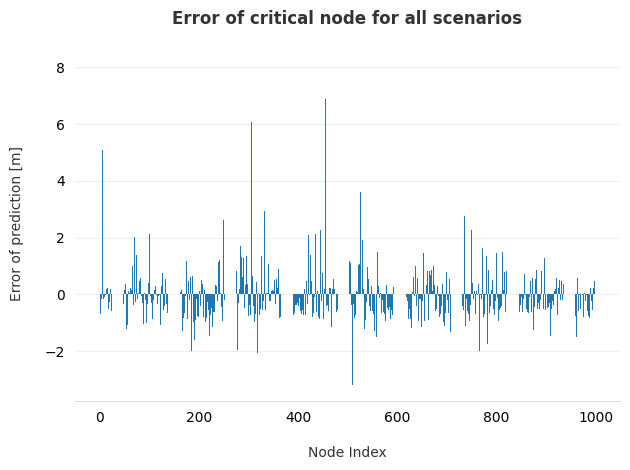

In [24]:
y_pred = NN.predict(X_test)

unnormalized_predictions = inverse_min_max_normalize(y_pred, min_target, max_target)

error = unnormalized_predictions - testing_targets

fig, ax = plt.subplots()

bars = ax.bar(
    x=np.arange(error.size),
    height=error,
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Node Index', labelpad=15, color='#333333')
ax.set_ylabel('Error of prediction [m]', labelpad=15, color='#333333')
ax.set_title(f'Error of critical node for all scenarios', pad=15, color='#333333', weight='bold')

fig.tight_layout()

In [25]:
y_pred_test = NN.predict(X_test)
rmse_test = np.sqrt(np.sum((unnormalized_predictions - testing_targets).reshape(-1)**2) / y_test.shape[0])
print("RMSE on test set for best performing model: {:.4e}".format(rmse_test))

RMSE on test set for best performing model: 9.5853e-01


Finally, we need to compute the RMSE for all samples in the test set to quantify our accuracy.

### Speed

We can calculate the time per scenario that the model takes.

In [26]:
start_time = time.time()
y_pred_test = NN.predict(X_test)
total_time = time.time() - start_time

num_test_sims = len(y_pred_test)

data_driven_exec_time_per_sim = total_time/num_test_sims
print(f'Data-driven model took {data_driven_exec_time_per_sim:.5f} seconds for {num_test_sims} scenarios')

Data-driven model took 0.00001 seconds for 1000 scenarios


Considering that the original model can take up to 0.04 seconds per scenario, we can estimate the potential gain in speed-up. (Speed-up = original_time/Data-driven_model_time)

In [27]:
original_time_per_sim = 0.04

speed_up = np.round(original_time_per_sim/data_driven_exec_time_per_sim, 2)
print('The data-driven model is', speed_up,'times faster than EPANET per scenario.')

The data-driven model is 6016.14 times faster than EPANET per scenario.


### 8. Save the metamodel

In [28]:
with open('model_Sklearn.p', 'wb') as handle:
    pickle.dump(NN, handle)

# Old code

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on the results on speed:
*   Which factors or components could make the model faster or slower on its execution?



### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on the loss curves:
*   What would you conclude about the overfitting or underfitting capabilities of the model?
*   Is this model adequate to be used? Why?

#### Answers:

*   What would you conclude about the overfitting or underfitting capabilities of the model?

Example:
"Both curves are decreasing, this means that the network is learning. However, the validation curve is below the training curve. This can indicate that the two distributions are different and the validation examples are easier than the training examples."

Other behaviours are explained [here](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/). 

*   Is this model adequate to be used? Why?

The students can argue that the model is learning, it is stabilizing, and the magnitude of the loss is low. Nevertheless, it is desirable that they question this curve and its ability to decide wheather the model is ready to be used or not. Further analysis should be carried out.




### Test the ANN as metamodel

For our application, we need the model to be both accurate and fast. Here, we will test those qualities.

#### Accuracy

Calculate the loss value for the test dataset

In [ ]:
normalized_testing_targets = (testing_targets - min_target)/(max_target - min_target)

testing_features_tensor = torch.tensor(testing_features, dtype = torch.float32)
normalized_testing_targets_tensor = torch.tensor(normalized_testing_targets, dtype = torch.float32)

testing_features_tensor = torch.tensor(testing_features, dtype = torch.float32)
normalized_testing_targets_tensor = torch.tensor(normalized_testing_targets, dtype = torch.float32)


testing_dataset = CustomDataset(testing_features_tensor, normalized_testing_targets_tensor)
testing_loader = DataLoader(testing_dataset, batch_size=len(testing_dataset), shuffle=True)

test_loss = evaluate_epoch(model, testing_loader, device=device)
num_test_sims = len(testing_dataset)

print('Test loss: ', test_loss)
print('Number of test scenarios: ', num_test_sims)

In [ ]:
for batch in testing_loader:
    features, targets = batch
    preds = model(features)
    
    unnormalized_preds   = preds*(max_target - min_target) + min_target
    unnormalized_targets = targets*(max_target - min_target) + min_target
    
    print(r2_score(unnormalized_targets.flatten(), unnormalized_preds.detach().numpy().flatten()))

#### Errors in unnormalized variable

Calculate the error in pressure for all the nodes in all the scenarios. This error matrix should be of shape [Scenarios , Nodes].

Remember that the variables were normalized for training purposes. However, the water utility is interested in the value of the output variable in physical units, in this case, pressure in mH2O. In order to do this, unnormalize the output variable knowing that the maximum and minimum pressures used to normalized the output variable were 59.56 mH2O and 0 mH2O, respectively.

In [ ]:
test_estimations = []
target_pressure = []

for batch in testing_loader:
  features, targets = batch

  test_estimations.append(max_target * (model(features)).detach().numpy())
  target_pressure.append(max_target * (targets).numpy())

estimated_pressure = np.vstack(test_estimations)
target_pressure = np.vstack(target_pressure)

error = target_pressure  - estimated_pressure

#### Error in pressure for all scenarios for one node

Plot the error of one node across test scenarios. 

In [ ]:
node_ID = 50
error_node = error[:, node_ID]

In [ ]:
fig, ax = plt.subplots()

bars = ax.bar(
    x=np.arange(error_node.size),
    height=error_node,
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Scenario', labelpad=15, color='#333333')
ax.set_ylabel('Error of prediction [m]', labelpad=15, color='#333333')
ax.set_title(f'Error of node {node_ID} across test scenarios', pad=15, color='#333333', weight='bold')

fig.tight_layout()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on the results accross scenarios:
*   Is the model satisfactorily fitting? 
*   If there are there outliers, do they have any pattern? 
*   Are these errors considerable?



#### Answers:

Based on the results accross scenarios:
*   Is the model satisfactorily fitting? 

The model seem to be performing adequately for most of the scenarios. However, there are some outliers that are worrying. These have errors of around 80%. The criteria to use this model or not, depends on the application and the people who would use it. The decision should be consulted with the water utility.

*   If there are there outliers, do they have any pattern? 

In order to answer this question, the students can analyse the outliers in the following part of the code. Most likely there won't be any noticeable patterns. These would be related to the hydraulic scenarios; for example, if the diameter of the pipe that connects the reservoir is too small it can cause an impact in the entire network, this case would be hard to detect with a data driven model without any physical constraints. 

*   Are these errors considerable?

Yes. Considering that the maximum pressure is around 60 mH2O; these errors are significant.



#### Error of all nodes in one scenario

Plot the error of all the nodes of one scenario. 

In [ ]:
sim_ID = 3
error_sim = error[sim_ID, :]

In [ ]:
fig, ax = plt.subplots()

bars = ax.bar(
    x=np.arange(error_sim.size),
    height=error_sim,
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Node Index', labelpad=15, color='#333333')
ax.set_ylabel('Error of prediction [m]', labelpad=15, color='#333333')
ax.set_title(f'Error of all the nodes for scenario {sim_ID}', pad=15, color='#333333', weight='bold')

fig.tight_layout()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on this error analysis:
*   How does it compare with the previous error analysis?
*   Is the model over- or under- predicting?
*   Would you recommend the water utility to use this model?
    *   Does your recommendation match with your previous recommendation?

#### Answers:

Based on this error analysis:
*   How does it compare with the previous error analysis?

This error analysis shows what is expected if the model is used for a single scenario. 

*   Is the model over- or under- predicting?

The error in one scenario indicates that the model is underpredicting for some nodes, but mostly, it is overpredicting. The simulations of the outliers show consistent errors across all nodes.The shape of the error curves, looks very similar, this indicates that the nodes are consistently being over(or under) predicted.

*   Would you recommend the water utility to use this model?
    *   Does your recommendation match with your previous recommendation?


Based on these results, the model could be recommendeded with some precautions. It is for the water utility to indicate if the expected error and the outliers are acceptable for the application they have in mind.



### Speed

We can calculate the time per scenario that the model takes.

In [ ]:
start_time = time.time()
for batch in testing_loader:
  features, targets = batch
  model(features)
total_time = time.time() - start_time

data_driven_exec_time_per_sim = total_time/num_test_sims
print(f'Data-driven model took {data_driven_exec_time_per_sim:.5f} seconds for {num_test_sims} scenarios')

Considering that the original model can take up to 0.04 seconds per scenario, we can estimate the potential gain in speed-up. (Speed-up = original_time/Data-driven_model_time)

In [ ]:
original_time_per_sim = 0.04

speed_up = np.round(original_time_per_sim/data_driven_exec_time_per_sim, 2)
print('The data-driven model is', speed_up,'times faster than EPANET per scenario.')

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on the results on speed:
*   Which factors or components could make the model faster or slower on its execution?



#### Answers:

Some components increase the computational burden on the model. These include: Number of layers, number of hidden units, number of k-hops. 



### 8. Save the metamodel

In [ ]:
with open('model.p', 'wb') as handle:
    pickle.dump(model, handle)

In [ ]:
torch.save(model.state_dict(), 'model_weights.pt')